<a id="top"></a>
# Long Period TESS Targets with Kepler Counterparts
***


## Prerequisites
- Python syntax
- astropy tables
- for loops
- Something about exoplanet transits, link to free resource

## Learning Goals

By the end of this tutorial, you will:

- 

To use as a guideline:
"Set a minimum threshold for orbital period (should be long-period orbits, greater than 6mos). Find all TESS 20-seconds targets that have data for these Kepler TCEs to create an even longer baseline."

## Introduction
The [Kepler initial and follow-on (K2) missions confirmed over 2,600 exoplanets](https://exoplanets.nasa.gov/keplerscience/) and contributed to an unprecedented exposion of knowledge about planetary systems in our galaxy. In addition to confirmed exoplanets, Kepler identified thousands more potential planetary candidates, referred to as Kepler Objects on Interest (KOI's). 

The Transiting Exoplanet Survey Satellite (TESS) began its observations just before the completion of the K2 mission; there may be long-period (greater than 6 months) exoplanets whose transits were observed by both missions. By combining observations from both missions, we could potentially view multiple transits and confirm the existence of new exoplanets. 

Possible transits observed by Kepler are called Threshold Crossing Events, or TCEs. More specifically, according to the [NASA Exoplanet Archive documentation](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_TCE_docs.html), 

>"A Threshold-Crossing Event (TCE) is a sequence of transit-like features in the flux time series of a given target that resembles the signature of a transiting planet to a sufficient degree that the target is passed on for further analysis."

NOT UPDATED: The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations


# Added by JRK
import requests
from astropy.io import ascii
import lightkurve as lk
import astropy.units as u # May not end up using?
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

***

## Load full table of Kepler Threshold Crossing Events, or TCEs and filter by period

The NASA Exoplanet Archive hosts many useful data tables, including the list of [Threshold Crossing Events (TCEs)](https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#tce). We'll use the Quarter 1 through Quarter 17 Data Release 24 (DR24) version. These TCEs were evaluated by an autovetter, a machine-learning program that classified TCEs into three categories: PC (Planet Candidate), AFP (Astrophysical False Positive), and NTP (Non-Transiting Phenomenon). More information about the autovetter can be found in [McCauliff et al. 2015 ApJ 806, 6](https://ui.adsabs.harvard.edu/abs/2015ApJ...806....6M/abstract).

We can point the astropy Table reader to a URL that contains the data table.

In [41]:
# Load the TCE DR24 table as an astropy table and view a preview.
# The online version doesn't have all the columns that you can download from the interactive table, in particular, the autovetter ones.
#tab=Table.read('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=q1_q17_dr24_tce',format='ascii.csv')
tab=Table.read('./q1_q17_dr24_tce_2023.05.29_11.07.52.csv',format='ascii.csv',comment='#') 
tab.pprint()

rowid  kepid   tce_plnt_num ... tce_dikco_msky tce_dikco_msky_err
----- -------- ------------ ... -------------- ------------------
    1  1162345            2 ...        0.46282                1.1
    2  1292087            2 ...        0.22049               0.22
    3  1293031            2 ...        0.41872              0.207
    4  1162345            3 ...        0.13742              0.196
    5  1164109            1 ...         15.207             0.0893
    6   757450            1 ...        0.12498             0.0763
    7   892667            1 ...        0.18106              0.124
    8   892772            1 ...         5.2002              0.165
    9  1026032            1 ...       0.064587              0.077
   10  1026032            2 ...        0.13865              0.084
  ...      ...          ... ...            ...                ...
20357 11809346            1 ...       0.090355             0.0786
20358 11826440            2 ...        0.58446              0.755
20359 1185

As we can see, the table has over 20,000 rows, so we will want to narrow down by targets most of interest for us. However, the "pretty print" preview of the table does not show us all of the columns. Let's see the names of all of the columns, and only retain those we will need.

In [42]:
print(tab.columns)

<TableColumns names=('rowid','kepid','tce_plnt_num','tce_rogue_flag','tce_delivname','rowupdate','tce_datalink_dvs','tce_datalink_dvr','tce_period','tce_period_err','tce_time0bk','tce_time0bk_err','tce_time0','tce_time0_err','tce_ror','tce_ror_err','tce_dor','tce_dor_err','tce_incl','tce_incl_err','tce_impact','tce_impact_err','tce_duration','tce_duration_err','tce_ingress','tce_ingress_err','tce_depth','tce_depth_err','tce_eccen','tce_eccen_err','tce_longp','tce_longp_err','tce_limbdark_mod','tce_ldm_coeff1','tce_ldm_coeff2','tce_ldm_coeff3','tce_ldm_coeff4','tce_num_transits','tce_trans_mod','tce_full_conv','tce_model_snr','tce_model_chisq','tce_model_dof','tce_robstat','tce_dof1','tce_dof2','tce_chisq1','tce_chisq2','tce_chisqgofdof','tce_chisqgof','tce_prad','tce_prad_err','tce_sma','tce_sma_err','tce_eqt','tce_eqt_err','tce_insol','tce_insol_err','tce_nkoi','tce_ioflag','tce_quarters','tce_steff','tce_steff_err','tce_slogg','tce_slogg_err','tce_smet','tce_smet_err','tce_sradius','

The NASA Exoplanet Archive provides detailed information about the [Data Columns in the Kepler TCE Table](https://exoplanetarchive.ipac.caltech.edu/docs/API_tce_columns.html). Some of the most important columns for us will be:
- kepid, Kepler identification number, which we can use when searching the MAST Archive.
- tce_period, the orbital period in days.
- tce_period_err, the error in the orbital period (also in days).
- tce_time0, the time of the center of the first detected transit in Barycentric Julian Day (BJD)
- tce_depth, the fraction of stellar flux lost at the maximum of the transit, in ppm.
- tce_duration, the duration of the observed transit, in hours.
- av_pred_class, the autovetter predicted classification (PC, AFP, or NTP)

We will only use those columns for now, to reduce the size of the table we are dealing with.

In [43]:
tab=tab['kepid','tce_period','tce_period_err','tce_time0','tce_depth','tce_duration','av_pred_class']

Additionally, we'd like to filter our table to only include Planetary Candidates of with a TCE period of greater than 6 months, or 180 days.

In [44]:
# Only include those that autovetter indicates as "PC" for Planetary Candidate
tab=tab[tab['av_pred_class']=='PC']
print('Number of Kepler TCEs marked as Planetary Candidates:',len(tab))

Number of Kepler TCEs marked as Planetary Candidates: 3900


We can see that of the over 20,000 TCEs, just under 20% were identified as likely planetary candidates. 
What is the distribution of the periods of those PCs? We can view a histogram of the 'tce_period' column.

Text(0, 0.5, 'Number of PCs')

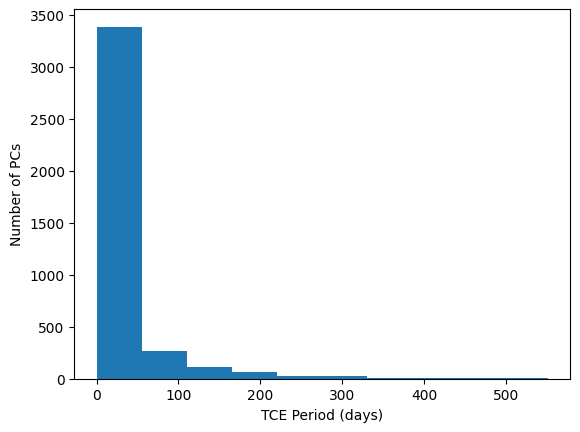

In [45]:
plt.hist(tab['tce_period'])
plt.xlabel('TCE Period (days)')
plt.ylabel('Number of PCs')

The vast majority of the TCE periods are fewer than 50 days. The planetary candidates that would most benefit from the long baseline afforded by combining the Kepler, K2, and TESS datasets are those with longer periods. Here, we'll again filter our table to just include those PCs with periods of greater than 6 months, or 180 days. 

In [46]:
# Only include those table rows with TCE period greater than 180 days
tab=tab[tab['tce_period']>180]
n=len(tab)
print('Number of Kepler TCEs marked PC and period > 180 days:',n)

Number of Kepler TCEs marked PC and period > 180 days: 123


Text(0, 0.5, 'Number of PCs')

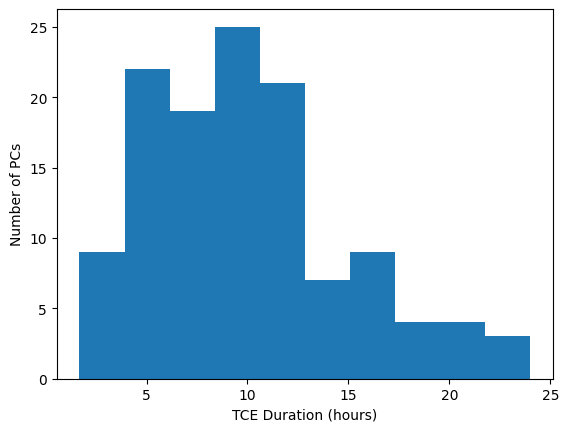

In [47]:
plt.hist(tab['tce_duration'])
plt.xlabel('TCE Duration (hours)')
plt.ylabel('Number of PCs')

## Find all TESS 20 to 600-second targets for these Kepler TCEs
The Kepler and K2 missions studied a limited portion of the sky, but TESS has studied (and continues to study) the full sky. This means that all Kepler and K2 identifications are likely to be included in the TESS Catalog. However, they may not all 

JRK what is the science reason for only 20-second targets? Why not also 2 min? Clearly 30 min not frequent enough.

### Finding observations in the MAST archive by the Kepler ID number
When we use astroquery.mast's Observations.query_object or query_object_count functions, the object's name will be resolved into sky coordinates (RA and Dec), so that all observations of that coordinate will be returned. This allows us to search by the Kepler ID column, even though TESS will not have used the Kepler ID to refer to the name of the target. Likewise, other ways to search the MAST archive, such as query_criteria, will also resolve the coordinates of the name input to 'objectname'. See the [astroquery documentation about MAST Queries](https://astroquery.readthedocs.io/en/latest/mast/mast.html) for more information. 

Unfortunately, this method of searching is time-intensive, which makes it very inconvenient when cross-matching hundreds or more targets from different missions. Let's illustrate this point with the first row in our filtered table. Notice that this call to MAST will take at least a few seconds; we can use the "time" magic command to tell us how long it takes.

In [8]:
# Query all observations in MAST that correspond to the coordinates of the first row's Kepler ID, within 1 arcsecond.
%time obs_table = Observations.query_object('KIC '+str(tab[0]['kepid']),radius=1*u.arcsec)

CPU times: user 57.9 ms, sys: 12.3 ms, total: 70.2 ms
Wall time: 6.15 s


In [9]:
# View the observation table
obs_table.pprint()

intentType obs_collection provenance_name ... srcDen   obsid   distance
---------- -------------- --------------- ... ------ --------- --------
   science           TESS            SPOC ...    nan  27463635      0.0
   science           TESS            SPOC ...    nan  62431369      0.0
   science           TESS            SPOC ...    nan  62870781      0.0
   science           TESS            SPOC ...    nan  92616912      0.0
   science           TESS            SPOC ...    nan  95133363      0.0
   science           TESS            SPOC ...    nan  62349937      0.0
   science           TESS            SPOC ...    nan  62793303      0.0
   science           TESS            SPOC ...    nan  91547081      0.0
   science           TESS            SPOC ...    nan  93772051      0.0
   science    SPITZER_SHA    SSC Pipeline ...    nan   1730213      0.0
       ...            ...             ... ...    ...       ...      ...
   science           HLSP             QLP ...    nan 129964724  

In [10]:
# View all unique entries in the 'target_name' column
np.unique(obs_table['target_name'])

137685450
2144.049
Kepler10-1-2-1-1-1-1-1
--
TESS FFI
TICA FFI
kplr002581316


From the above, we can see that inputting an 'objectname' of 'KIC 2581316' from the Kepler Input Catalog (KIC) identification number, we find all the observations of that target from all different missions - even if they did not specifically refer to the name of the target by it. 

### Get coordinates and TESS Input Catalog (TIC) numbers from Vizier
We will find that it is far faster to search MAST for TESS observations by TESS Input Catalog (TIC) number. To do that, we need to figure out the TICs that correspond to the KICs. To do this, we'll search the Tess Input Catalog, which is hosted in Vizier: [TESS Input Catalog version 8.2 (TIC v.8.2)(Paegert+,2021)](http://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=IV/39/tic82&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa)

First, we'll setup astroquery to search Vizier in such a way that we do not limit the number of rows returned, and we specifically want to return the columns corresponding to coordinates (RA and Dec), TIC, and KIC. Next, we'll create new columns that match the data types we will find in Vizier.

In [48]:
Vizier.ROW_LIMIT = -1
v=Vizier(columns=['_RAJ2000','_DEJ2000','TIC','KIC'])

In [49]:
tab.add_columns([np.zeros(n),np.zeros(n),np.zeros(n,dtype=np.int32),np.zeros(n,dtype=np.int64)],
                names=['_RAJ2000','_DEJ2000','KIC','TIC'])

We will query Vizier for each row in our table of TCEs, and then save the resulting RA, Dec, KIC (just to confirm!) and TIC in our new columns. To guard against connectivity errors interrupting the workflow, we will put the Vizier query in a [try statement](https://docs.python.org/3/tutorial/errors.html#handling-exceptions).

In [50]:
# Query a subset of the TESS Input Catalog 
#result=Vizier.query_object('KIC 2581316',catalog=['IV/39/tic82']) # Length: 282
#for i,row in enumerate(tab):
for i,row in enumerate(tab):
    # Use a "try/except" because sometimes there is no response
    try:
        result=v.query_object('KIC '+str(row['kepid']),radius=1*u.arcsec,catalog=['IV/39/tic82'])
        # If there is more than one result, choose the one with matching KIC.
        if len(result[0])>1: result=result[0][result[0]['KIC']==row['kepid']]
        tab[i]['_RAJ2000','_DEJ2000','KIC','TIC']=result[0][0]['_RAJ2000','_DEJ2000','KIC','TIC']
    except:
        print('Error in',i)
        continue

Error in 58
Error in 75


We can now view the updated table and confirm that the KIC values from Vizier match the 'kepid' values from our original table, except in any rows where an error was found.

In [56]:
tab.pprint()
print(np.where(tab['kepid']!=tab['KIC']))
print(tab[[58,75]])

 kepid   tce_period tce_period_err tce_time0 ...   KIC       TIC    TESS fast
-------- ---------- -------------- --------- ... -------- --------- ---------
 2581316    217.832    7.71254e-05 2455070.0 ...  2581316 137685450         8
 2975770    369.079     0.00262336 2455130.0 ...  2975770 121395761         3
 2576107    205.583    0.000156979 2455070.0 ...  2576107 137220754         0
 3103227    225.583     0.00304541 2455110.0 ...  3103227 121395435         0
 3326377     198.71    0.000624291 2454990.0 ...  3326377 120962548         0
 3645438    386.372      0.0107079 2455290.0 ...  3645438 137151626         0
 3634051    453.544     0.00352963 2455190.0 ...  3634051 121457557         2
 3747817    184.772     0.00139617 2455050.0 ...  3747817 137319097         0
 4918309    186.436     0.00047676 2454980.0 ...  4918309 122301308         0
 4760478    287.378      0.0024477 2455180.0 ...  4760478 184011870         0
     ...        ...            ...       ... ...      ...       

### Finding the number of TESS lightcurves by TIC
To examine each of the 123 long-period planetary candidates that also have TESS lightcurves, it is more efficient to just query MAST for the counts (total numbers) of observations that match our criteria; we can do this with query_criteria_count. Here are the criteria we will include:
- target_name, the TIC number as an integer.
- project = TESS
- obs_collection = HLSP for "High Level Science Product"
- dataproduct_type = 'timeseries' because we are interested in light curves, not images
- t_exptime = [20.0,600.0], this limits ourselves to lightcurves with observing cadences (time between images) of 20 to 600 seconds. Some TESS light curves in the MAST archive are 1800.0 s or 30 minutes; because exoplanet transits last on the order of hours, we'll be better able to model the transit with higher frequency images.

In [52]:
tab.add_column(np.zeros(n,dtype=int),name='TESS fast')

In [53]:
for i,row in enumerate(tab):
    obs_count = Observations.query_criteria_count(target_name=row['TIC'],
                                        project='TESS',obs_collection='HLSP',
                                        dataproduct_type='timeseries',
                                       t_exptime=[20.0,600.0])
    tab['TESS fast'][i]=obs_count

(array([  2,   3,   4,   5,   7,   8,   9,  11,  14,  15,  16,  17,  21,
        22,  23,  24,  25,  26,  27,  28,  30,  31,  32,  34,  35,  39,
        40,  42,  48,  49,  51,  52,  53,  56,  58,  60,  63,  64,  65,
        67,  70,  71,  74,  75,  76,  79,  83,  87,  89,  90,  91,  93,
        94,  97, 100, 101, 102, 103, 104, 107, 110, 112, 114, 115, 118,
       119, 120, 122]),)


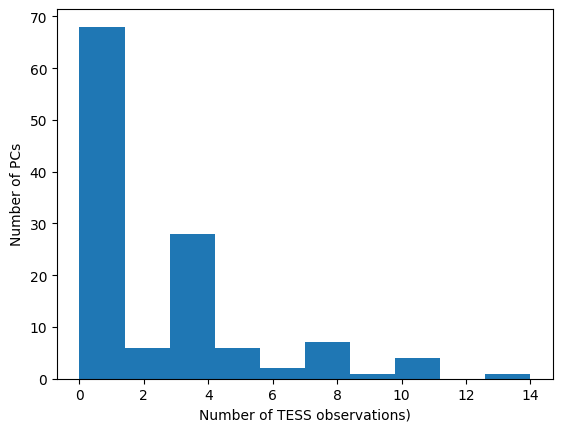

In [57]:
plt.hist(tab['TESS fast'])
plt.xlabel('Number of TESS observations)')
plt.ylabel('Number of PCs')
print(np.where(tab['TESS fast']==0))

In [73]:
tab=tab[tab['TESS fast']>0]
print(len(tab))
print(tab[2])

55
 kepid  tce_period tce_period_err tce_time0 tce_depth tce_duration av_pred_class     _RAJ2000       _DEJ2000      KIC      TIC    TESS fast
------- ---------- -------------- --------- --------- ------------ ------------- --------------- -------------- ------- --------- ---------
3634051    453.544     0.00352963 2455190.0     845.7        17.01            PC 287.97545896654 38.74028625567 3634051 121457557         2


In [71]:
# Idea; use 'tce_period','tce_period_err','tce_time0' to predict when future transits would happen,
# then search for TESS lightcurves that contain that time period? Can that be done?

# Examine the combined light curves for one target

JRK seems safest for now to return by coords, seems 'KIC 

In [67]:
# KIC 2581316, TIC 137685450, RA 292.62745521591, DEC 37.86013507452
# This one has 8 TESS lightcurves, and makes lk unhappy.
#search_result=lk.search_lightcurve(2581316) # Returns 35 data products, Kepler and TESS
#search_result=lk.search_lightcurve('KIC '+str(2581316)) # Returns 18 data products, all Kepler
#search_result=lk.search_lightcurve(137685450) # Returns 0 data products
#search_result=lk.search_lightcurve('TIC '+str(137685450)) # Returns 17 data products, all TESS
#search_result=lk.search_lightcurve('292.62745521591,37.86013507452') # Returns 35 data products, Kepler and TESS
# If do exptime=[20,600], will narrow it down, but that means will also exclude kepler 1800 s
#search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr002581316,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr002581316,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr002581316,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr002581316,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr002581316,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr002581316,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr002581316,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr002581316,0.0
8,Kepler Quarter 08,2011,Kepler,1800,kplr002581316,0.0


In [74]:
search_result=lk.search_lightcurve('287.97545896654,38.74028625567')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr003634051,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr003634051,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr003634051,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr003634051,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr003634051,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr003634051,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr003634051,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr003634051,0.0
8,Kepler Quarter 08,2011,Kepler,1800,kplr003634051,0.0


In [75]:
# Load 'em all. Where does it "go"?
lc_collection = search_result.download_all()

In [76]:
lc_collection

LightCurveCollection of 23 objects:
    0: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=0 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=7 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 3634051" QUARTER=9 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <KeplerLightCurv

/opt/conda/envs/tess/lib/python3.8/site-packages/lightkurve/collections.py:264: LightkurveWarning: Some but not all of the light curves in the collection appear to be normalized. You may wish to use `normalize=True` to ensure all are normalized.
  warnings.warn(


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

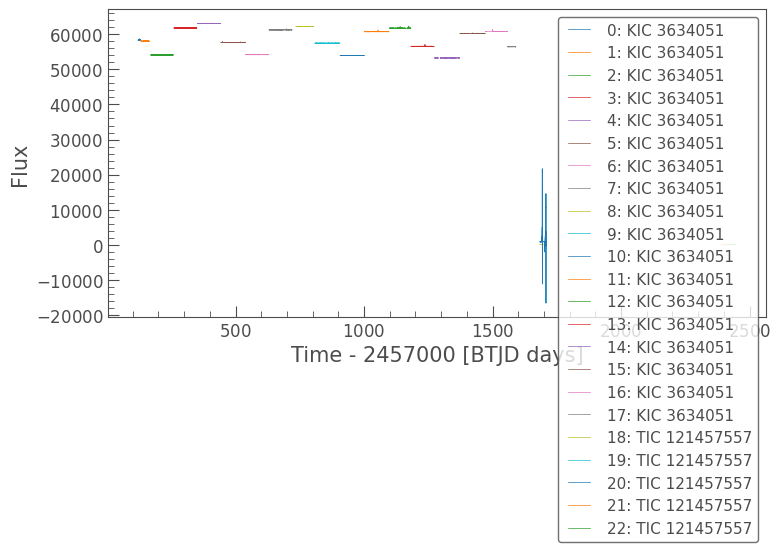

In [79]:
# It's mad here.
lc_collection.plot()

In [69]:
# Could be interesting to visualize just Kepler, then just TESS, then combined.
# Could also indicate the expected transit times, based on 'tce_period','tce_period_err','tce_time0'
lc_stitched = lc_collection.stitch()
lc_stitched.plot()

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
/opt/conda/envs/tess/lib/python3.8/site-packages/lightkurve/collections.py:213: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  warnings.warn(
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value

TableMergeError: The 'quality' columns have incompatible types: ['int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'str32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32', 'int32']

Where possible (if the code supports it), use code examples that visually display the data in the tutorial. For example, if you are showing an object such as a Table, display a preview of the table:

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author(s):** Jessie Blogs, Jenny V. Medina, Thomas Dutkiewicz <br>
**Keyword(s):** Tutorial, lightkurve, kepler, introduction, template <br>
**Last Updated:** Aug 2022 <br>
**Next Review:** Mar 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 